# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: **«Смарт»** и **«Ультра»**. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
Описание тарифов

**Тариф «Смарт»**

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 3 рубля
        сообщение: 3 рубля
        1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        минута разговора: 1 рубль
        сообщение: 1 рубль
        1 Гб интернет-трафика: 150 рублей

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Путь к файлам:

* /datasets/calls.csv.
* /datasets/internet.csv.
* /datasets/messages.csv.
* /datasets/tariffs.csv. 
* /datasets/users.csv.


1. [Обзор данных](#start)
    * [Описание данных](#description)
    * [Вывод](#conclution1)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропусков](#missed)
    * [Дополнительные расчеты](#adds)
    * [Вывод](#conclution2)
3. [Анализ данных](#analitics)
    * [Проверка гипотез](#hypoteses)
    * [Вывод](#conclution3)
4. [Общий вывод](#conclusion)


<a id="start"></a>
## Обзор данных

<a id="description"></a>
### Описание данных
Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tarif` — название тарифного плана

Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [89]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [90]:
calls_df = pd.read_csv('/datasets/calls.csv')
internet_df = pd.read_csv('/datasets/internet.csv')
messages_df = pd.read_csv('/datasets/messages.csv')
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
users_df = pd.read_csv('/datasets/users.csv')


In [91]:
def explore_data(df):
    display(
        "Сводная информация:", df.info(),
        "10 строк:", df.head(10),
        "Столбцы:", df.columns,
        "Числовое описание:", df.describe(),
        "Сумма пропусков:", df.isna().sum(),
        "Доля пропусков:", df.isna().mean(),
        "Явные дубликаты:", df.duplicated().sum(),
       # "Корреляция:", ads_df.corr(),
        #sns.heatmap(ads_df.corr())
    )
    

In [92]:
data_dict = {'calls': calls_df, 'internet': internet_df, 'messages': messages_df, 'tariffs': tariffs_df, 'users': users_df}
for df_name in data_dict:
    print(f'{df_name}: ')
    explore_data(data_dict[df_name])

calls: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


'Сводная информация:'

None

'10 строк:'

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


'Столбцы:'

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

'Числовое описание:'

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


'Сумма пропусков:'

id           0
call_date    0
duration     0
user_id      0
dtype: int64

'Доля пропусков:'

id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64

'Явные дубликаты:'

0

internet: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


'Сводная информация:'

None

'10 строк:'

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


'Столбцы:'

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

'Числовое описание:'

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


'Сумма пропусков:'

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

'Доля пропусков:'

Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64

'Явные дубликаты:'

0

messages: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


'Сводная информация:'

None

'10 строк:'

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


'Столбцы:'

Index(['id', 'message_date', 'user_id'], dtype='object')

'Числовое описание:'

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


'Сумма пропусков:'

id              0
message_date    0
user_id         0
dtype: int64

'Доля пропусков:'

id              0.0
message_date    0.0
user_id         0.0
dtype: float64

'Явные дубликаты:'

0

tariffs: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


'Сводная информация:'

None

'10 строк:'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


'Столбцы:'

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

'Числовое описание:'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


'Сумма пропусков:'

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

'Доля пропусков:'

messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64

'Явные дубликаты:'

0

users: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


'Сводная информация:'

None

'10 строк:'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


'Столбцы:'

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

'Числовое описание:'

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


'Сумма пропусков:'

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

'Доля пропусков:'

user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

'Явные дубликаты:'

0

<a id="conclution1"></a>
### Вывод
В этом разделе провели знакомство с каждым набором данных, были обнаружены пропуски в столбце`churn_date`.
Необходимо выполнить преобразование типов для дат.
Дубликаты не обнаружены


Text(0, 0.5, 'Frequency')

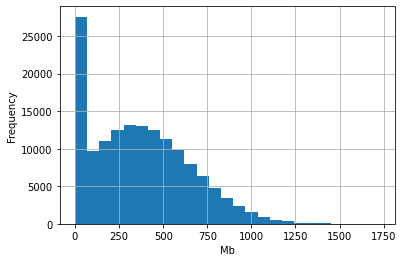

In [93]:
internet_df['mb_used'].hist(bins=25)
plt.xlabel('Mb')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

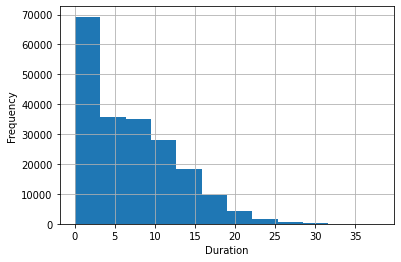

In [94]:
calls_df['duration'].hist(bins=12)
plt.xlabel('Duration')
plt.ylabel('Frequency')

<AxesSubplot:>

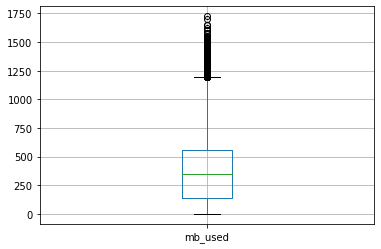

In [95]:
#internet_df[internet_df['mb_used']==0].head(10)
internet_df.boxplot(column='mb_used')

<a id="preprocessing"></a>
## Подготовка данных

В этом разделе соберем данные в единую таблицу, заполним обнаруженные пропуски, выполним преобразования типов данных, а также выполним дополнительные расчеты и добавление новых данных в таблицу

Переименуем столбец `'tariff_name'` в `'tariff'`, чтобы по нему можно было объединить таблицы `tariffs_df` и `clients`

In [96]:
tariffs_df = tariffs_df.rename(columns={'tariff_name' : 'tariff'})
clients = users_df.merge(tariffs_df, on='tariff')
clients.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,1000,30720,3000,1950,150,1,1
2,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,1000,30720,3000,1950,150,1,1
3,1013,36,NaN,Иваново,Борис,Андреенко,2018-11-14,ultra,1000,30720,3000,1950,150,1,1
4,1016,58,NaN,Омск,Марица,Сазонова,2018-11-21,ultra,1000,30720,3000,1950,150,1,1


Напишем функцию, которая преобразует типы столбцов 'session_date', 'call_date', 'message_date' в даты и добавит новый столбец 'month', который соответствует месяцу оказанной услуги

In [97]:
def service_date_to_datetime(service_dataset_dict, f_format='%Y-%m-%d'): # {'call_date': calls_df}
    for service in service_dataset_dict:
        service_dataset_dict[service][service] = pd.to_datetime(service_dataset_dict[service][service], format=f_format)
        service_dataset_dict[service]['month'] = service_dataset_dict[service][service].dt.month_name()
        #display(service_dataset_dict[service].head())

In [98]:
service_date_to_datetime({'session_date': internet_df, 'call_date' : calls_df, 'message_date': messages_df})

определим количество отправленных сообщений по месяцам

In [99]:
messages_grouped =(messages_df.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
                   .reset_index()
                   .rename(columns={'id': 'messages_per_month'}))#messages_df.groupby(by=['user_id', 'month']).agg('count').reset_index().head()
messages_grouped.shape

(2717, 3)

Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

In [100]:
calls_df['duration'] = np.ceil(calls_df['duration'])

Определим количество израсходованных минут разговора по месяцам

In [101]:
calls_grouped = calls_df.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()

In [102]:
#internet_df.pop('Unnamed: 0')


Определим объем израсходованного интернет-трафика по месяцам;

In [103]:
internet_grouped = internet_df.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()

Объединим услуги в общую таблицу

In [104]:
services = (internet_grouped.merge(calls_grouped, on=['user_id','month'], how='outer')
            .merge(messages_grouped, on=['user_id','month'], how='outer'))

Наконец, соберем все данные пользователей в единую таблицу

In [105]:
megaline_info = services.merge(clients, on='user_id', how='left')

In [106]:
megaline_info[megaline_info['mb_used']==0].head(10).columns

Index(['user_id', 'month', 'mb_used', 'duration', 'messages_per_month', 'age',
       'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff',
       'messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute'],
      dtype='object')

<a id="missed"></a>
### Заполнение пропусков

In [107]:
megaline_info.isna().sum()

user_id                     0
month                       0
mb_used                    11
duration                   40
messages_per_month        497
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

В столбцах `'mb_used', 'duration', 'messages_per_month'` пропуски означают, что услуга не использовалась, поэтому заменим их на 0

In [108]:
megaline_info[['mb_used', 'duration', 'messages_per_month']] = megaline_info[['mb_used', 'duration', 'messages_per_month']].fillna(0)

In [109]:
megaline_info.isna().sum()

user_id                     0
month                       0
mb_used                     0
duration                    0
messages_per_month          0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

<a id="adds"></a>
### Дополнительные расчеты

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [110]:
megaline_info['gb_used'] = (megaline_info['mb_used'] / 1024).apply(np.ceil).astype('Int64')
megaline_info['gb_per_month_included'] = np.ceil(megaline_info['mb_per_month_included'] / 1024).astype('Int64')

In [111]:
megaline_info['messages_per_month'] = megaline_info['messages_per_month'].astype('Int64')
megaline_info['duration'] = megaline_info['duration'].astype('Int64')

In [112]:
megaline_info['churn_date'] = pd.to_datetime(megaline_info['churn_date'], format='%Y-%m-%d')
megaline_info['reg_date'] = pd.to_datetime(megaline_info['reg_date'], format='%Y-%m-%d')

In [113]:
megaline_info.head(10)

,user_id,month,mb_used,duration,messages_per_month,age,churn_date,city,first_name,last_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included
0,1000,August,14055.93,408,81,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,14,30
1,1000,December,9817.61,333,70,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,10,30
2,1000,July,14003.64,340,75,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,14,30
3,1000,June,23233.77,172,60,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,23,30
4,1000,May,2253.49,159,22,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,3,30
5,1000,November,14756.47,338,58,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,15,30
6,1000,October,14702.49,350,73,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,15,30
7,1000,September,14568.91,466,57,52,NaT,Краснодар,Рафаил,Верещагин,...,ultra,1000,30720,3000,1950,150,1,1,15,30
8,1001,December,14036.66,414,0,41,NaT,Москва,Иван,Ежов,...,smart,50,15360,500,550,200,3,3,14,15
9,1001,November,18429.34,430,0,41,NaT,Москва,Иван,Ежов,...,smart,50,15360,500,550,200,3,3,18,15


In [114]:
megaline_info.user_id.unique().shape

(498,)

In [115]:
set(users_df.user_id.unique()) - set(megaline_info.user_id.unique() )

{1128, 1371}

In [116]:
display(users_df.query('user_id == 1371 or user_id==1128'))
display(services.query('user_id == 1371 or user_id==1128'))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


,user_id,month,mb_used,duration,messages_per_month



 Вот эти два разгильдяя чуть больше, чем через неделю расторгли договор. Их надо удалить из таблицы пользователей.

Расчитаем помесячную выручку с каждого пользователя: 
* вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;
* остаток умножем на значение из тарифного плана; 
* прибавим абонентскую плату, соответствующую тарифному плану

In [117]:
def count_profit(row):
    msg_out_of_limit = minutes_out_of_limit = mb_out_of_limit = 0
    
    if row['messages_per_month'] > row['messages_included']:
        msg_out_of_limit = row['messages_per_month'] - row['messages_included']
    if row['duration'] > row['minutes_included']:
        minutes_out_of_limit = row['duration'] - row['minutes_included']
    if row['gb_used'] > row['gb_per_month_included']:
        mb_out_of_limit = row['gb_used'] - row['gb_per_month_included']
    
    return (msg_out_of_limit * row['rub_per_message'] + 
                     minutes_out_of_limit * row['rub_per_minute'] +
                     mb_out_of_limit * row['rub_per_gb'] +
                     row['rub_monthly_fee'])

In [118]:
megaline_info['profit_per_month'] = megaline_info.apply(count_profit, axis=1)
megaline_info.head(5)

,user_id,month,mb_used,duration,messages_per_month,age,churn_date,city,first_name,last_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_per_month_included,profit_per_month
0,1000,August,14055.93,408,81,52,NaT,Краснодар,Рафаил,Верещагин,...,1000,30720,3000,1950,150,1,1,14,30,1950
1,1000,December,9817.61,333,70,52,NaT,Краснодар,Рафаил,Верещагин,...,1000,30720,3000,1950,150,1,1,10,30,1950
2,1000,July,14003.64,340,75,52,NaT,Краснодар,Рафаил,Верещагин,...,1000,30720,3000,1950,150,1,1,14,30,1950
3,1000,June,23233.77,172,60,52,NaT,Краснодар,Рафаил,Верещагин,...,1000,30720,3000,1950,150,1,1,23,30,1950
4,1000,May,2253.49,159,22,52,NaT,Краснодар,Рафаил,Верещагин,...,1000,30720,3000,1950,150,1,1,3,30,1950


<a id="conclution2"></a>
### Вывод
В этом разделе объединили данные в единую таблицу megaline_info , заполнили обнаруженные пропуски в столбцах `'mb_used', 'duration', 'messages_per_month'`
Расчитали количество израсходованных минут разговора, отправленных сообщений, объем израсходованного интернет-трафика по месяцам
На каждого пользователя расчитали помесячную выручку 

<a id="analitics"></a>
## Анализ данных 
Выясним сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

Посчитаем среднее количество, дисперсию и стандартное отклонение

In [119]:
mean_var_std = megaline_info.groupby(by='tariff')[['duration', 'gb_used', 'messages_per_month', 'profit_per_month']].agg(['mean', 'var','std'])
mean_var_std

duration                               gb_used                       \
              mean            var         std       mean        var       std   
tariff                                                                          
smart   417.934948   36219.315784  190.313730  16.328847  33.028705  5.747061   
ultra    526.62335  100873.633397  317.606098  19.494416  97.091686  9.853511   

       messages_per_month                         profit_per_month  \
                     mean          var        std             mean   
tariff                                                               
smart           33.384029   796.812958  28.227876      1289.973531   
ultra           49.363452  2285.266143  47.804457      2070.152284   

                                   
                  var         std  
tariff                             
smart   669785.708006  818.404367  
ultra   141516.745079  376.187114

duration


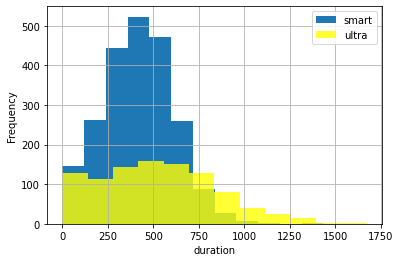

messages_per_month


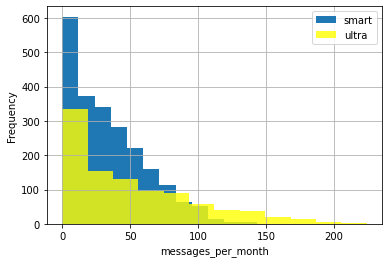

gb_used


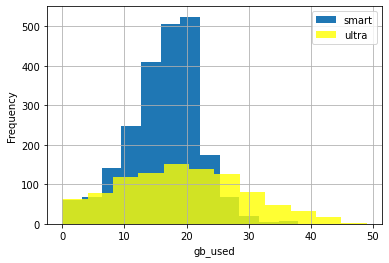

profit_per_month


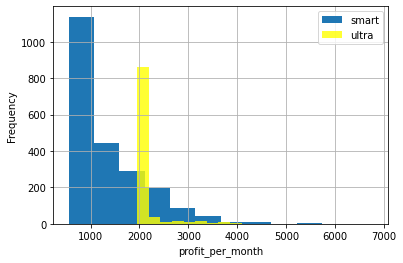

In [120]:
for column in ['duration', 'messages_per_month', 'gb_used', 'profit_per_month']:
    print(column)
    #fig, ax = plt.subplots()
    megaline_info.query('tariff == "smart"')[column].hist( bins=12,  label='smart')
    megaline_info.query('tariff == "ultra"')[column].hist( bins=12, alpha=0.8,color='yellow', label='ultra')
    plt.legend(['smart', 'ultra'])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Все распределения близки к нормальному за исключением распределения колличества сообщений по месяцам. Большая часть потребителей перестает использовать сообщения как средство коммуникации.

Среднемесячная выручка от пользователей тарифа smart  выше, да и аудитория шире

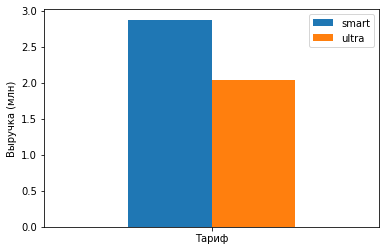

In [121]:
df = pd.DataFrame({'smart': megaline_info.query('tariff == "smart"')['profit_per_month'].sum()/1000000,
                   'ultra': megaline_info.query('tariff == "ultra"')['profit_per_month'].sum()/1000000}, index=['Тариф'])
df.plot.bar(rot=0)
plt.ylabel('Выручка (млн)')
plt.show()

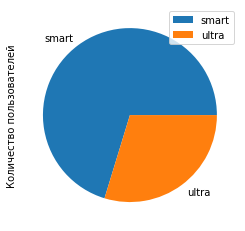

In [122]:
df = pd.DataFrame({'Количество пользователей': [megaline_info.query('tariff == "smart"').user_id.unique().shape[0],
                   megaline_info.query('tariff == "ultra"').user_id.unique().shape[0]]}, index=['smart','ultra'])
df.plot.pie(y='Количество пользователей')
plt.show()

<a id="hypoteses"></a>
### Проверка гипотез

Чтобы проверить гипотезу о равенстве среднего двух
генеральных совокупностей по взятым из них выборкам, применим
метод scipy.stats.ttest_ind()

Нулевая гипотеза **H₀** - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны .

Альтернативная гипотеза **H₁** - средняя выручка пользователей тарифов «Ультра» и «Смарт» **не** равны

In [123]:
alpha = 0.01
result = st.ttest_ind(megaline_info.query('tariff == "smart"')['profit_per_month'],
                     megaline_info.query('tariff == "ultra"')['profit_per_month'],
                     equal_var=False)
# p-value - это вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна
print('p-value: ', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевая гипотеза верна')

p-value:  4.2606313931076085e-250
Отвергаем нулевую гипотезу


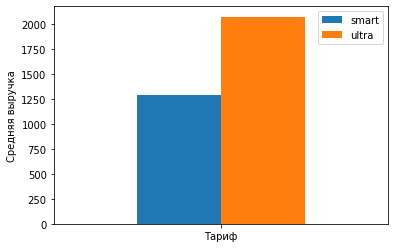

In [124]:
df = pd.DataFrame({'smart': megaline_info.query('tariff == "smart"')['profit_per_month'].mean(),
                   'ultra': megaline_info.query('tariff == "ultra"')['profit_per_month'].mean()}, index=['Тариф'])
df.plot.bar(rot=0)
plt.ylabel('Средняя выручка')
plt.show()

Нулевая гипотеза H₀ - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

Альтернативная гипотеза H₁ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


In [125]:
alpha = 0.0
result = st.ttest_ind(megaline_info.query('city == "Москва"')['profit_per_month'],
                     megaline_info.query('city != "Москва"')['profit_per_month'],
                     equal_var=False)
# p-value - это вероятность получить наблюдаемый результат при условии, что нулевая гипотеза верна
print('p-value: ', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевая гипотеза верна')

p-value:  0.5257376663729298
Нулевая гипотеза верна


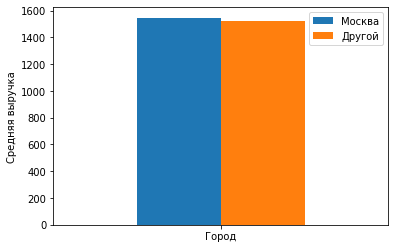

In [126]:
df = pd.DataFrame({'Москва': megaline_info.query('city == "Москва"')['profit_per_month'].mean(),
                   'Другой': megaline_info.query('city != "Москва"')['profit_per_month'].mean()}, index=['Город'])
df.plot.bar(rot=0)
plt.ylabel('Средняя выручка')
plt.show()

<a id="conclution3"></a>
### Вывод
В этом разделе удалось установить, что :
* средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны
* средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

<a id="conclution"></a>
## Вывод
 Итак, в этом проекте удалось провести предварительный анализ тарифов на небольшой выборке клиентов.
 Установили среднемесячное потребление услуг для каждого доступного тарифа, Большая часть потребителей перестает использовать сообщения как средство коммуникации
 Среднемесячная выручка от пользователей тарифа ultra выше
 Проверили гипотезы и установили, что:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны
* средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

График ниже показывает, что тариф `smart` приносит больше дохода (кажется пора менять условия для `ultra` 💰💰💰)

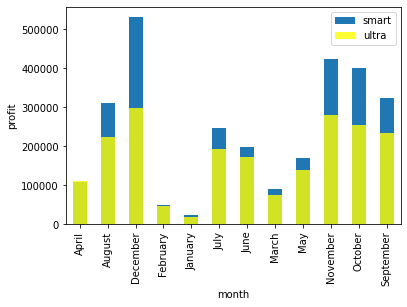

In [129]:
fig, ax = plt.subplots()
megaline_info.query('tariff=="smart"')[['month','profit_per_month']].groupby(by='month').agg('sum').plot.bar(label='smart', ax = ax)
megaline_info.query('tariff=="ultra"')[['month','profit_per_month']].groupby(by='month').agg('sum').plot.bar(label='ultra',alpha=0.8, color='yellow', ax=ax)
plt.legend(['smart', 'ultra'])
plt.xlabel('month')
plt.ylabel('profit')
plt.show()